In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import diffrax
jax.config.update("jax_enable_x64", True)

In [2]:
def sprott_case_N(t, y, args):
    a, b, c = y
    dadt = -args[0] * b
    dbdt = a + c ** 2
    dcdt = 1 + b - 2 * c
    return jnp.array([dadt, dbdt, dcdt])

# https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/simulation_scripts/lorenz_lyapunov_exponent_jax.ipynb
def lorenz(t, u, args):
    x, y, z = u
    sigma, rho, beta = args
    x_dot = sigma * (y - x)
    y_dot = x * (rho - z) - y
    z_dot = x * y - beta * z
    u_dot = jnp.array([x_dot, y_dot, z_dot])
    return u_dot

def add_perturbation_to_rhs(rhs_fn):

    def rhs_w_perturbation(t, y, args):
        n_vars = len(y)
        n_eps = n_vars // 2
        eps = y[-n_eps:]
        primal, tangent = jax.jvp(lambda y: rhs_fn(t, y, args), (y[:-n_eps],), (eps,))
        return jnp.concatenate([primal, tangent])

    return rhs_w_perturbation

sprott_case_N_w_perturbation = add_perturbation_to_rhs(sprott_case_N)
lorenz_rhs_w_perturbation = add_perturbation_to_rhs(lorenz)
print(sprott_case_N_w_perturbation(0, jnp.array([1., 1., 1., 1, 1, 1]), jnp.array([1.0])))



[-1.  2.  0. -1.  3. -1.]


In [3]:
def sim_approx_mLCE(ode_term, args):
    # Warmup
    dt0 = 0.01
    tot_step = 500_000
    t1 = dt0 * tot_step
    y0 = jnp.ones(6)
    solution = diffrax.diffeqsolve(
        terms=diffrax.ODETerm(ode_term),
        solver=diffrax.Tsit5(),
        t0=0,
        t1=t1,
        dt0=dt0,
        y0=jnp.ones(6),
        args=jnp.array(args),
        saveat=diffrax.SaveAt(ts=[t1]),
        max_steps=1000_000
    )
    warm_y0 = jnp.concatenate([solution.ys[-1][:3], jnp.array(np.random.randn(3))])

    tot_step = 10000
    t1 = dt0 * tot_step
    y0 = warm_y0
    solution = diffrax.diffeqsolve(
        terms=diffrax.ODETerm(ode_term),
        solver=diffrax.Tsit5(),
        t0=0,
        t1=t1,
        dt0=dt0,
        y0=y0,
        args=jnp.array(args),
        saveat=diffrax.SaveAt(ts=jnp.arange(0, t1, 0.01)),
        max_steps=100_0000
    )
    return solution

In [4]:
import matplotlib.pyplot as plt

def plot_trace(solution):
    # Plot all 3-dimensions
    plt.plot(solution.ts, solution.ys[:, 0], label='x')
    plt.plot(solution.ts, solution.ys[:, 1], label='y')
    plt.plot(solution.ts, solution.ys[:, 2], label='z')
    plt.xlabel('t')
    plt.legend()
    plt.show()

    # plot the first x and z dimensions of y
    plt.plot(solution.ys[:, 1], solution.ys[:, 2], marker=',', linewidth=0.25)
    plt.xlabel('y')
    plt.ylabel('z')
    plt.show()

def plot_approx_mLCE(solution, true_val=None):
    tot_step = len(solution.ts)
    dt0 = solution.ts[1] - solution.ts[0]
    eps = solution.ys[:, 3:]
    eps_norm = jnp.linalg.norm(eps, axis=1)
    eps_norm_ratio = eps_norm[1:] / eps_norm[:-1]
    mLCE_at_time_t = jnp.cumsum(jnp.log(eps_norm_ratio)) / (jnp.arange(1, tot_step) * dt0)

    plt.plot(mLCE_at_time_t, label='approximated value')
    if true_val:
        plt.hlines(true_val, 0, tot_step, colors='r', linestyles='dashed', label="True value")
    plt.grid()
    plt.xlabel('steps')
    plt.title('Approximated mLCE over time (mLCE = {:.4f})'.format(mLCE_at_time_t[-1]))
    plt.legend()


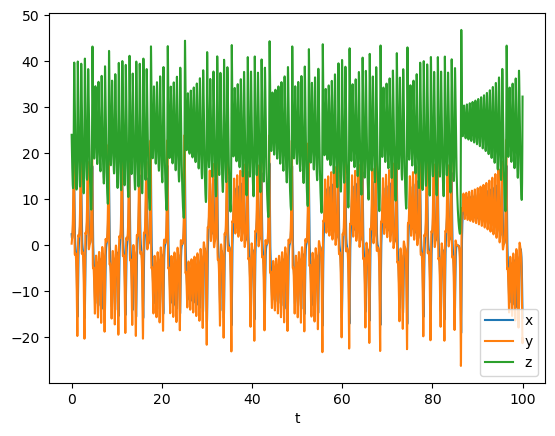

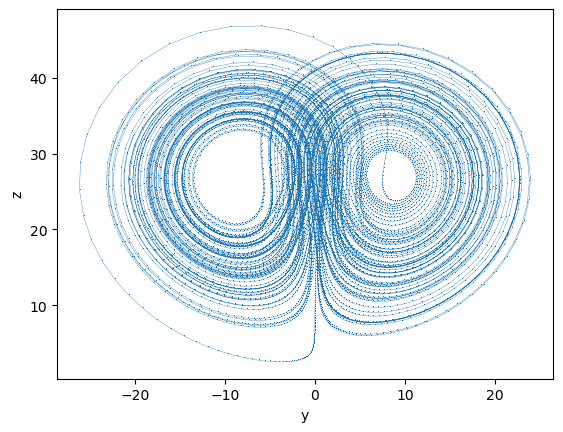

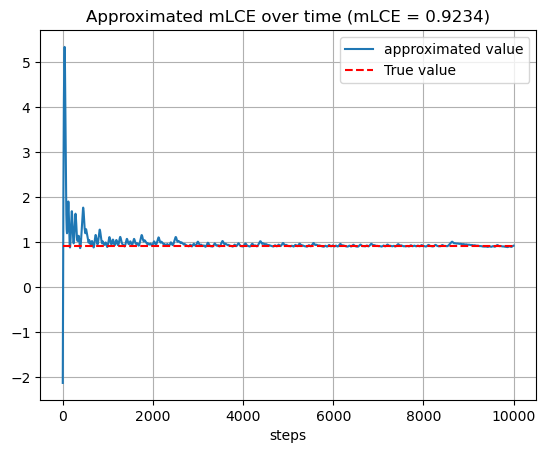

In [5]:
solution_lorenz = sim_approx_mLCE(lorenz_rhs_w_perturbation, jnp.array([10.0, 28.0, 8/3]))
plot_trace(solution_lorenz)
plot_approx_mLCE(solution_lorenz, true_val=0.9056)

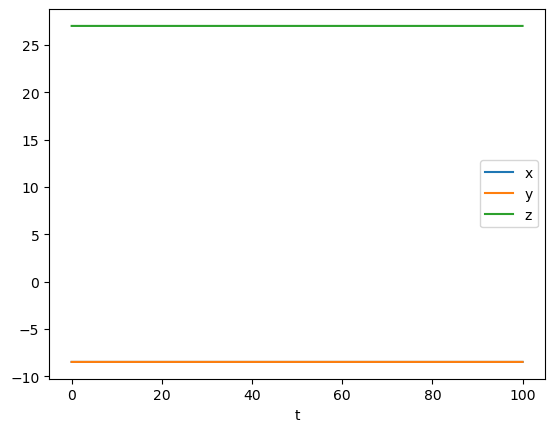

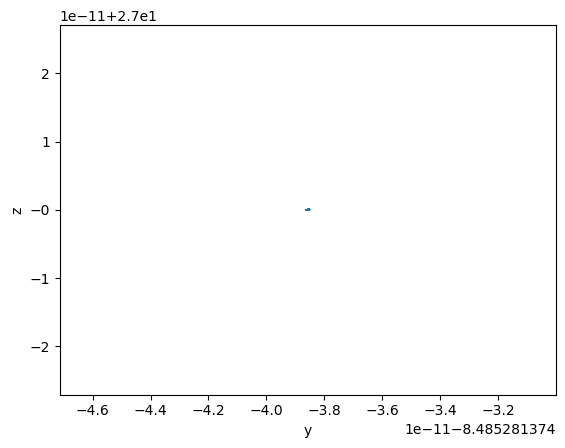

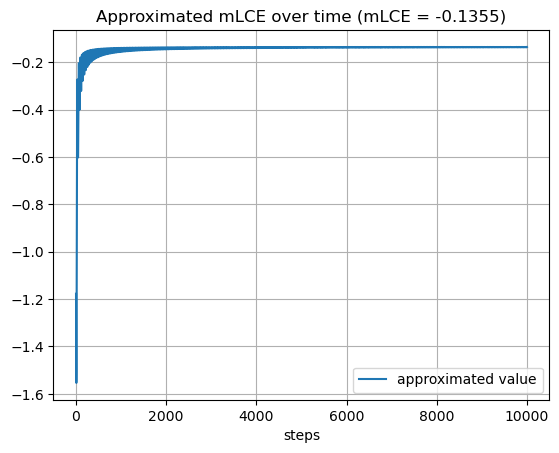

In [6]:
solution_lorenz = sim_approx_mLCE(lorenz_rhs_w_perturbation, jnp.array([5.0, 28.0, 8/3]))
assert (solution_lorenz.ys != jnp.nan).all()
plot_trace(solution_lorenz)
plot_approx_mLCE(solution_lorenz)

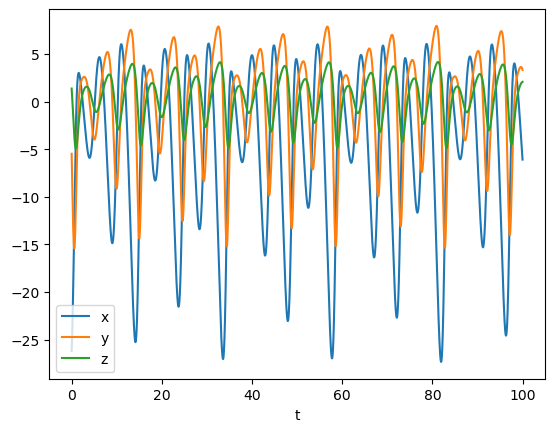

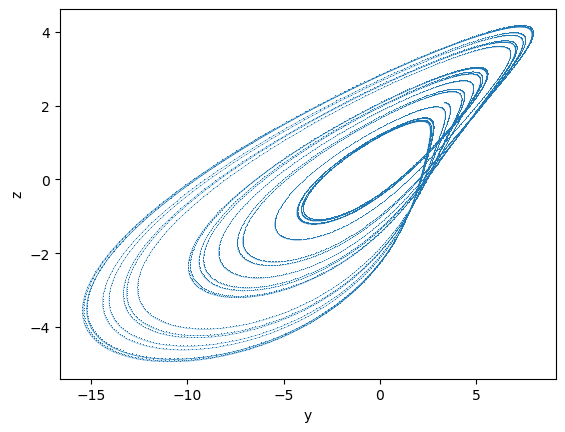

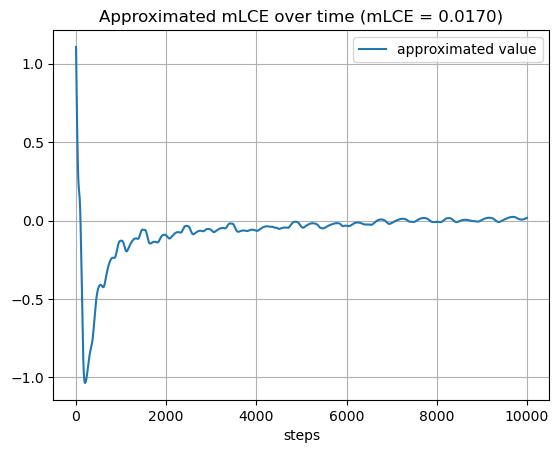

In [7]:
solution_sprott = sim_approx_mLCE(sprott_case_N_w_perturbation, jnp.array([2]))
plot_trace(solution_sprott)
plot_approx_mLCE(solution_sprott)

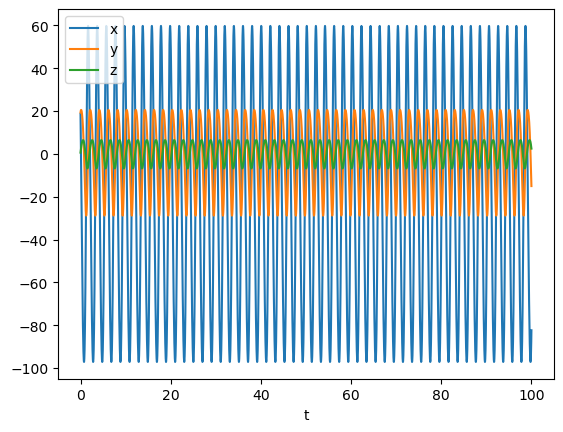

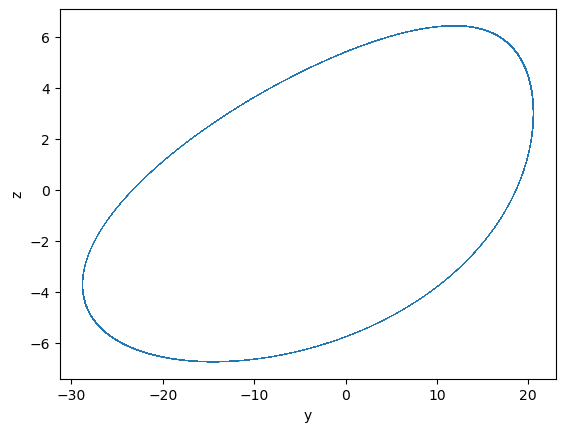

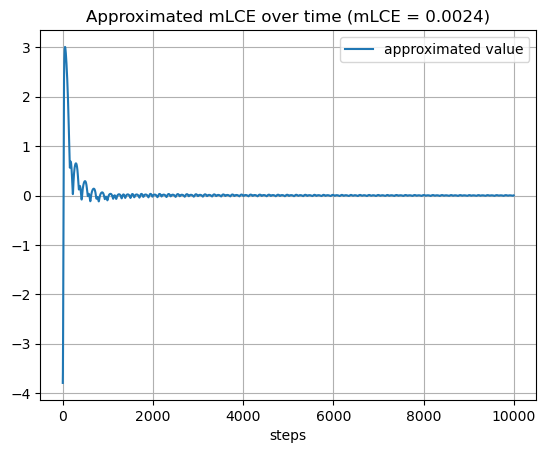

In [8]:
solution_sprott = sim_approx_mLCE(sprott_case_N_w_perturbation, jnp.array([10]))
plot_trace(solution_sprott)
plot_approx_mLCE(solution_sprott)